In [1]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
import os
import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize
import matplotlib.pyplot as plt

In [2]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [3]:
# in the actual script this will be provided as an argument
chrom = 2

In [4]:
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [5]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [6]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [7]:
## read in genotype file (plink format)
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:05<00:00, 121.71s/it]


In [8]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [9]:
## subset to relevant donors (from sample mapping file)
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [10]:
## and decompose such that K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)
del K

In [11]:
# number of samples (cells)
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [12]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [13]:
# environments
# cells by PCs (10)
E_file = input_files_dir+"10PCs.csv" 
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [14]:
random = np.random.RandomState(0)
# Permute E
idx_E = np.arange(E.shape[0])
cell2donor = {}
for _, row in sample_mapping.iterrows():
    assert row["phenotype_sample_id"] not in cell2donor
    cell2donor[row["phenotype_sample_id"]] = row["genotype_individual_id"]

E_donors = np.asarray([cell2donor[cell] for cell in E.coords["cell"].values], str)

for donor in np.unique(E_donors):
    idx_E[E_donors == donor] = random.permutation(idx_E[E_donors == donor])

In [15]:
# subselect to only SNPs on right chromosome
G_sel = G.where(G.chrom == str(chrom), drop=True)

In [16]:
G_sel

<xarray.DataArray 'genotype' (sample: 1610, variant: 903871)>
dask.array<where, shape=(1610, 903871), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
  * variant  (variant) object '2_2_10587_C_G' ... '2_2_243185679_C_T'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object 'HPSI0216i-tony_5' ... 'HPSI0416pf-cihd'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '2' '2' '2' '2' '2' '2' ... '2' '2' '2' '2' '2'
    snp      (variant) object '2_10587_C_G' '2_10596_G_T' ... '2_243185679_C_T'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 10587 10596 10797 ... 243178647 243184570 243185679
    a0       (variant) object 'C' 'G' 'C' 'C' 'C' 'G' ... 'G' 'T' 'T' 'A' 'C'
    a1       (variant) object 'G' 'T' 'T' 'G' 'G' 'C' ... 'T' 'G' 'G' 'G' 'T'

In [17]:
# select down to relevant individuals
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [18]:
# get eigendecomposition of EEt
[U, S, _] = economic_svd(E)
us = U * S
# get decomposition of K*EEt
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]

In [19]:
Ls[1].shape

(33964, 125)

In [20]:
# Phenotype (genes X cells)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
phenotype.head()

,21843_1#10,21843_1#100,21843_1#101,21843_1#102,21843_1#103,21843_1#105,21843_1#106,21843_1#107,21843_1#108,21843_1#109,...,24539_8#88,24539_8#89,24539_8#90,24539_8#91,24539_8#92,24539_8#93,24539_8#94,24539_8#95,24539_8#97,24539_8#98
ENSG00000000003_TSPAN6,5.520777,6.456208,5.878671,4.860824,5.903640,4.513537,6.401983,5.909216,5.366645,3.228852,...,5.841814,6.104105,6.275649,7.029407,5.806978,6.199875,7.014180,6.228476,6.217161,6.034232
ENSG00000000419_DPM1,5.392461,6.065923,6.838769,6.614268,6.512403,5.527439,6.525591,6.381135,6.157296,6.248478,...,6.543807,6.369119,7.185421,6.337047,6.162437,5.885993,7.431358,7.013124,4.851771,4.937248
ENSG00000000457_SCYL3,0.000174,0.352597,0.000000,0.825955,2.201697,0.262446,0.000000,1.506837,0.283516,3.241977,...,0.017386,0.949668,0.035526,0.032044,1.773369,0.000000,0.108025,1.756339,2.492943,1.363441
ENSG00000000460_C1orf112,1.471928,4.536968,4.318528,5.373009,4.636175,4.225468,0.409785,3.668277,3.057933,3.154891,...,4.720967,3.791536,2.696476,4.227515,4.243689,3.227508,2.621121,3.950978,3.926914,4.211904
ENSG00000001036_FUCA2,2.908802,3.867327,3.321747,3.736476,4.917576,2.456866,0.577839,4.777404,2.873857,2.536708,...,3.070608,4.491643,4.206249,3.695005,2.652845,4.221847,3.188030,4.741496,3.872743,4.374577


In [21]:
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [22]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl.head()

,snp_id,feature,stage
0,5_149826526_C_T,ENSG00000164587_RPS14,ips
1,11_57283988_C_T,ENSG00000134809_TIMM10,ips
2,12_56401085_G_A,ENSG00000197728_RPS26,ips
3,17_79634162_T_G,ENSG00000214087_ARL16,ips
4,6_31486901_T_C,ENSG00000198563_DDX39B,ips


In [23]:
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()
genes

array(['ENSG00000229150_CRYGEP', 'ENSG00000183891_TTC32',
       'ENSG00000144120_TMEM177', 'ENSG00000138032_PPM1B',
       'ENSG00000237651_C2orf74', 'ENSG00000035141_FAM136A',
       'ENSG00000196208_GREB1', 'ENSG00000136717_BIN1',
       'ENSG00000240344_PPIL3', 'ENSG00000213160_KLHL23',
       'ENSG00000171055_FEZ2', 'ENSG00000198586_TLK1',
       'ENSG00000121989_ACVR2A', 'ENSG00000136682_CBWD2',
       'ENSG00000168385_SEPT2', 'ENSG00000152076_CCDC74B',
       'ENSG00000132305_IMMT', 'ENSG00000171227_TMEM37',
       'ENSG00000213639_PPP1CB', 'ENSG00000138439_FAM117B',
       'ENSG00000115446_UNC50', 'ENSG00000134330_IAH1',
       'ENSG00000119013_NDUFB3', 'ENSG00000151665_PIGF',
       'ENSG00000071967_CYBRD1', 'ENSG00000132031_MATN3',
       'ENSG00000115866_DARS', 'ENSG00000197927_C2orf27A',
       'ENSG00000115539_PDCL3', 'ENSG00000151353_TMEM18',
       'ENSG00000144061_NPHP1', 'ENSG00000162976_PQLC3',
       'ENSG00000172954_LCLAT1', 'ENSG00000144115_THNSL2',
       'ENSG000

In [24]:
len(genes)

230

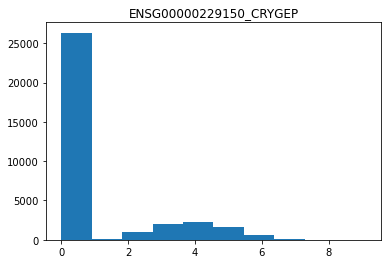

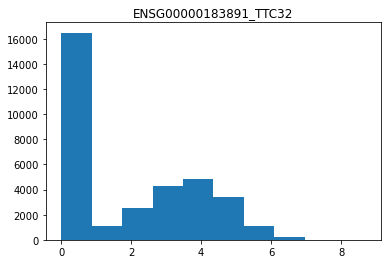

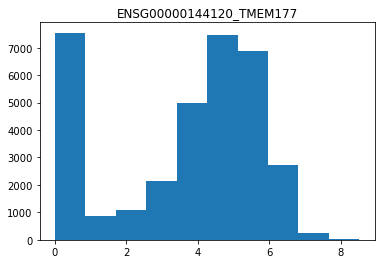

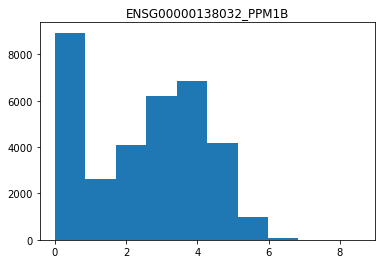

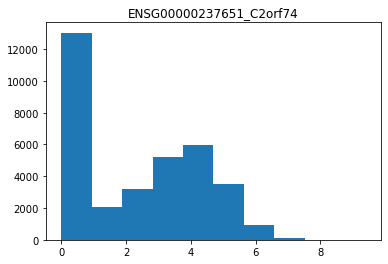

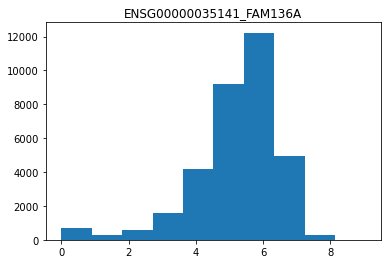

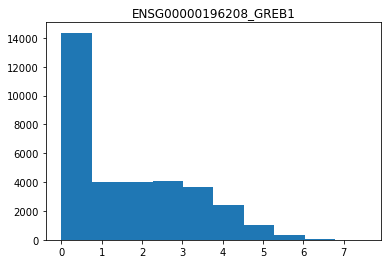

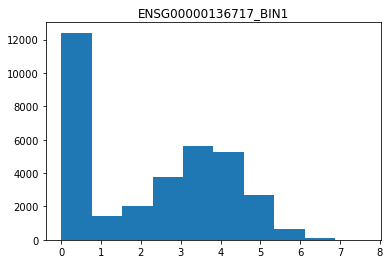

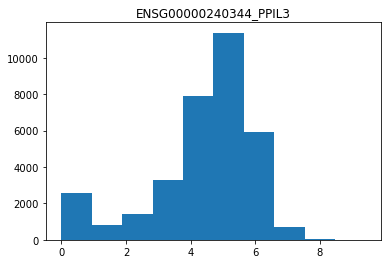

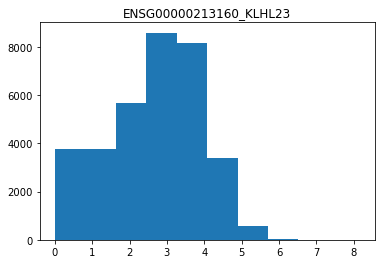

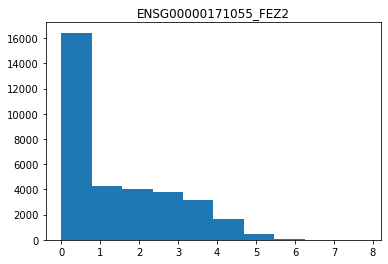

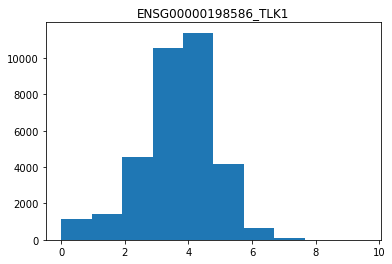

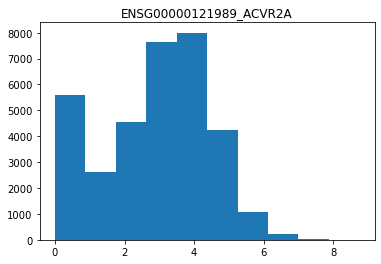

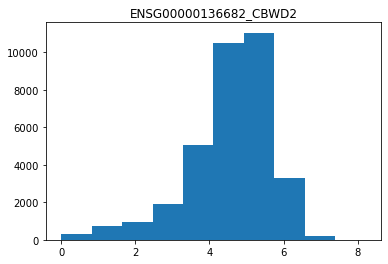

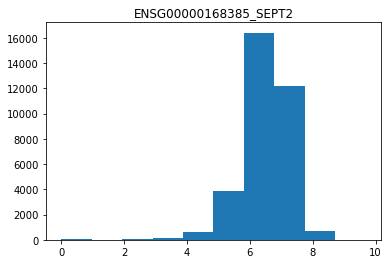

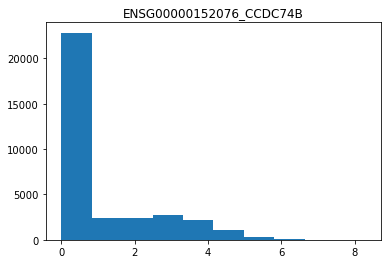

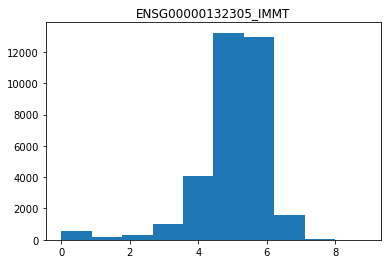

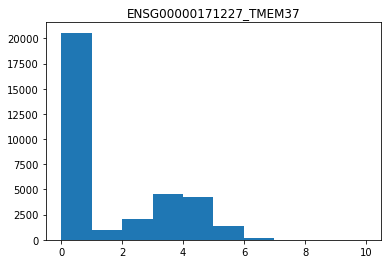

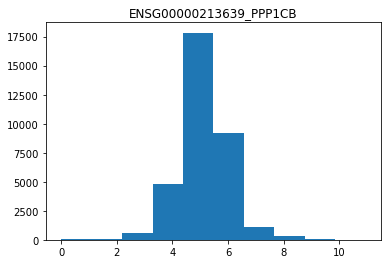

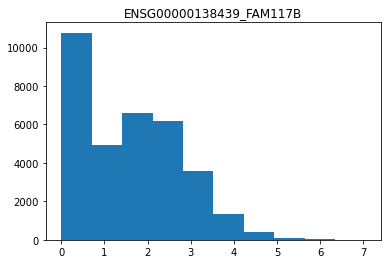

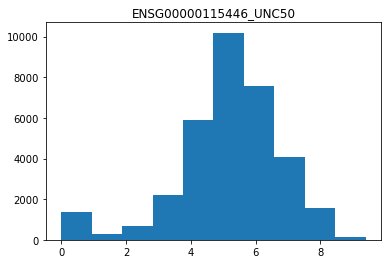

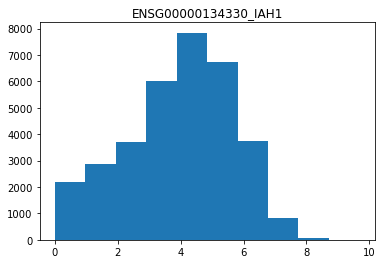

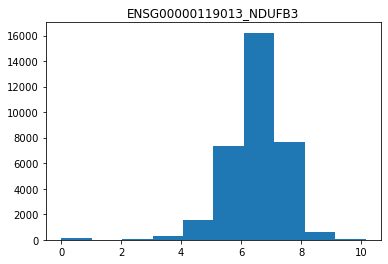

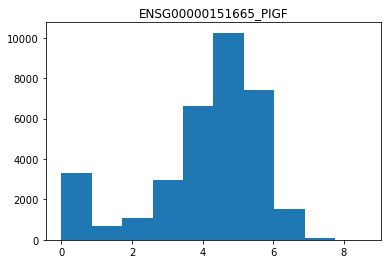

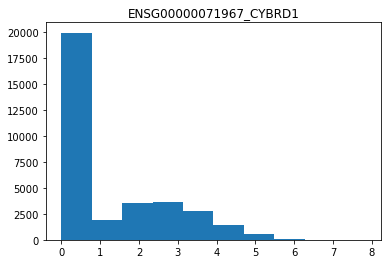

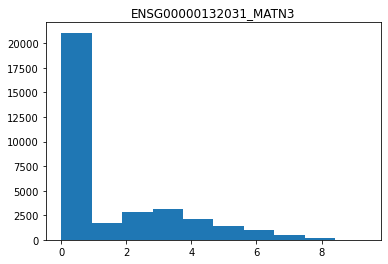

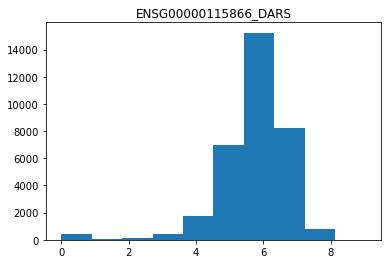

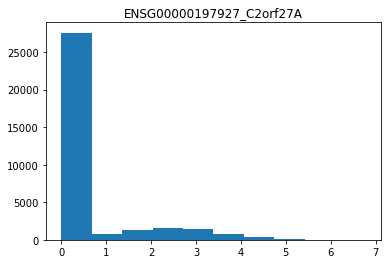

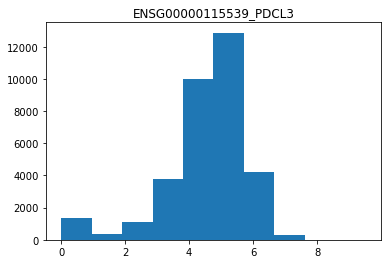

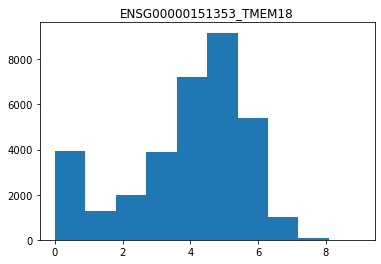

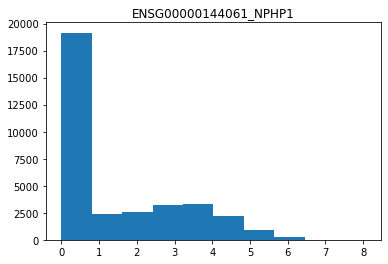

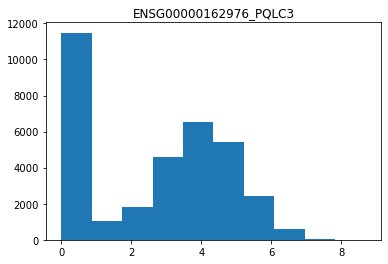

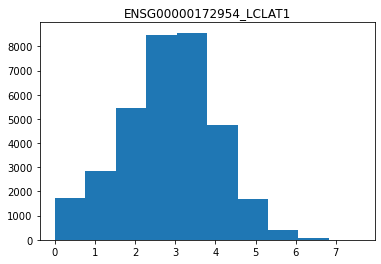

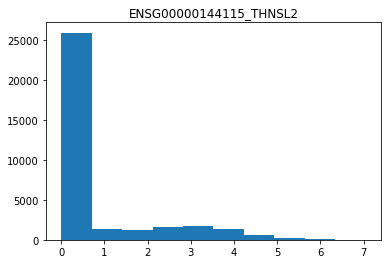

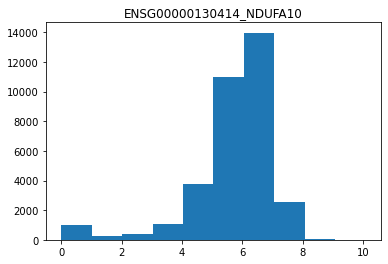

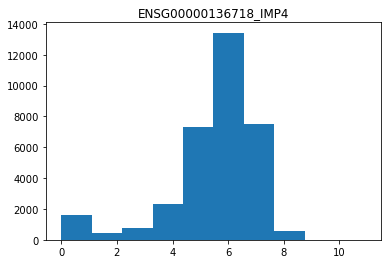

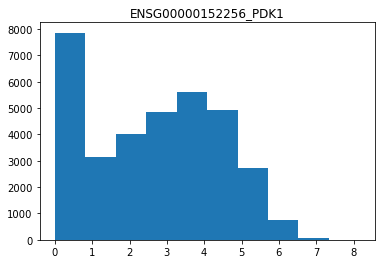

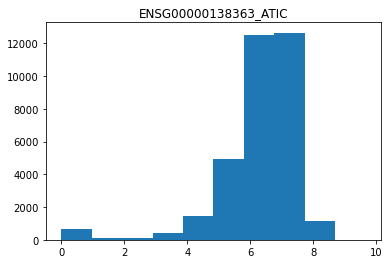

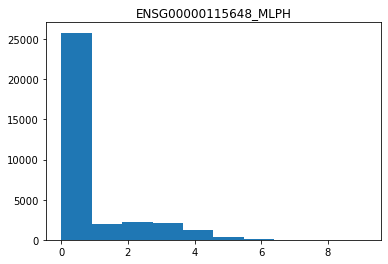

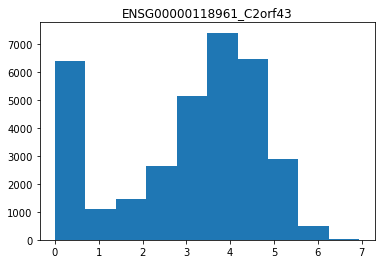

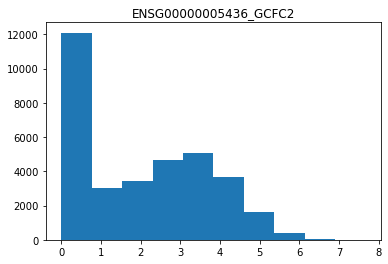

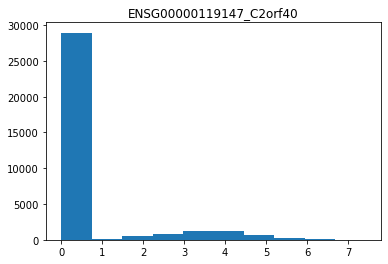

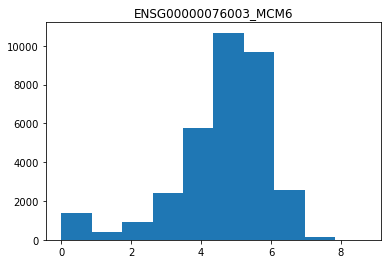

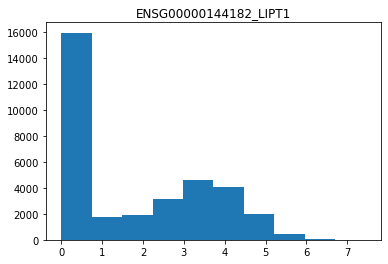

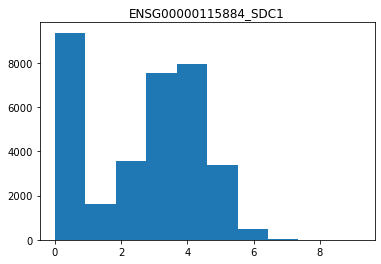

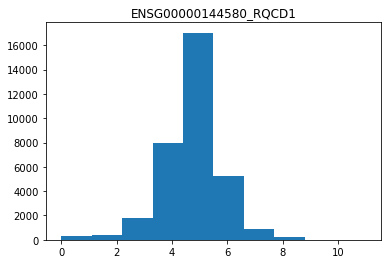

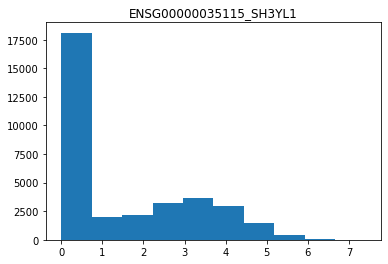

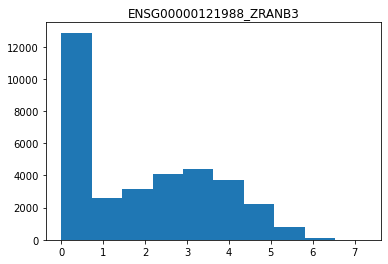

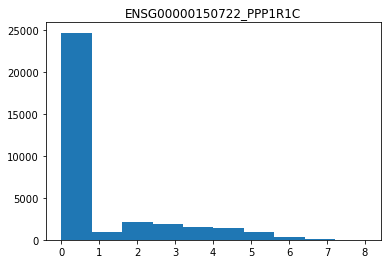

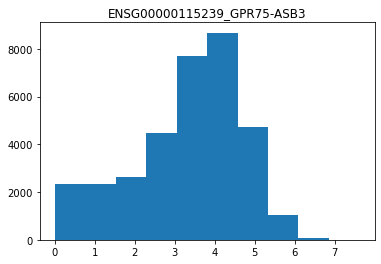

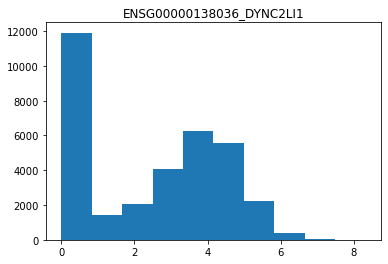

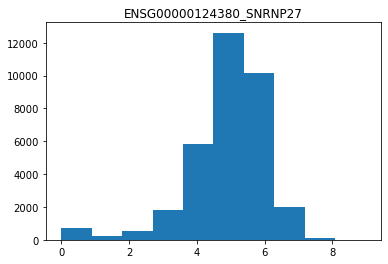

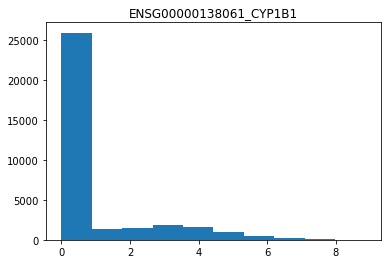

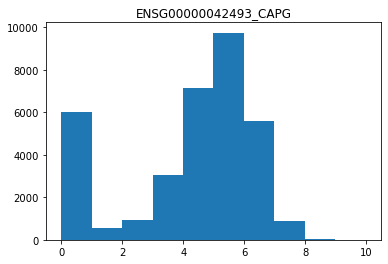

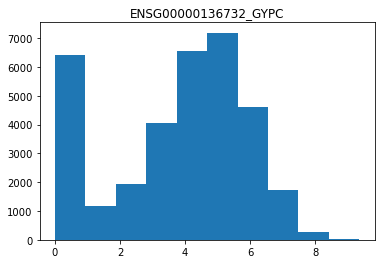

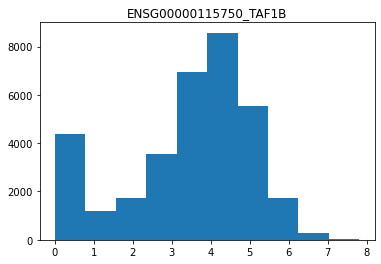

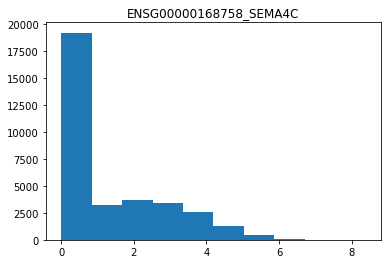

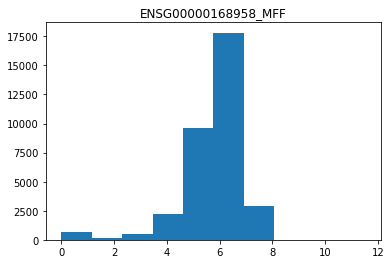

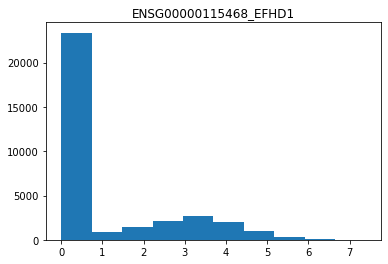

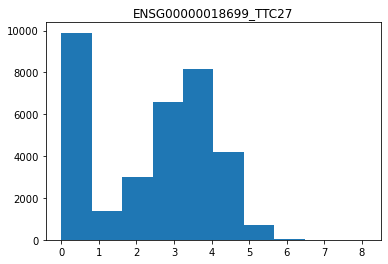

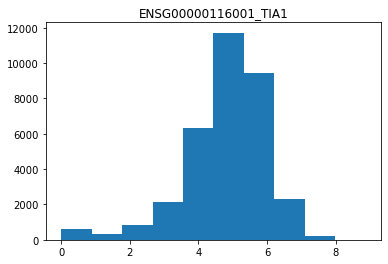

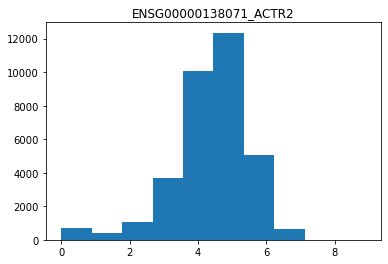

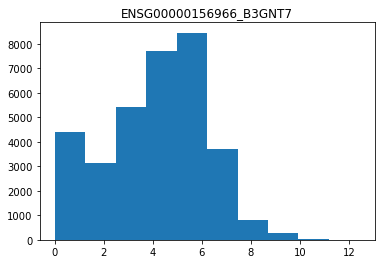

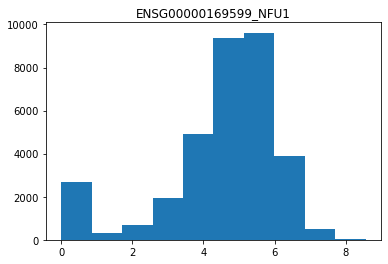

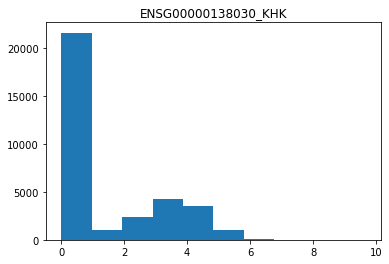

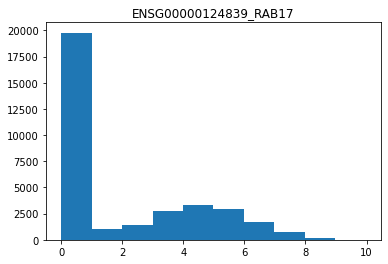

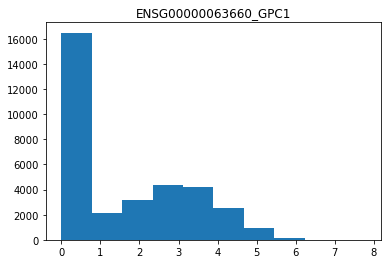

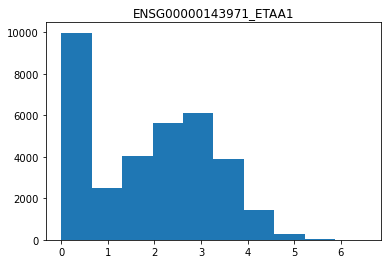

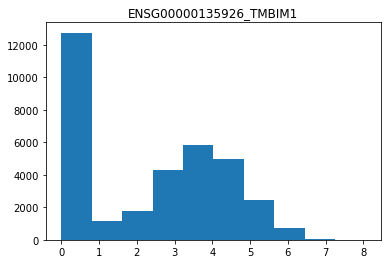

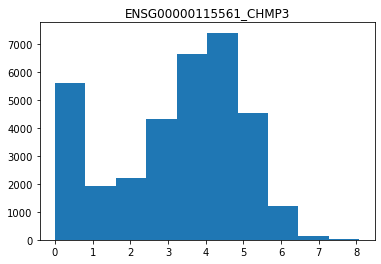

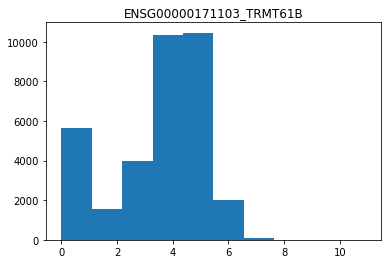

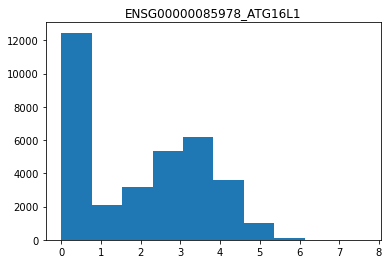

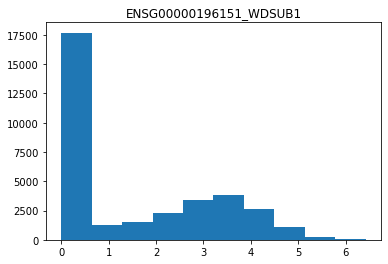

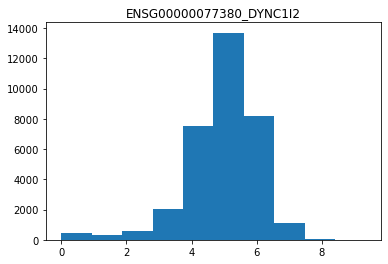

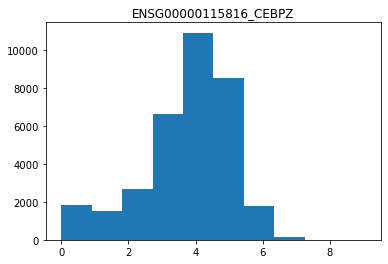

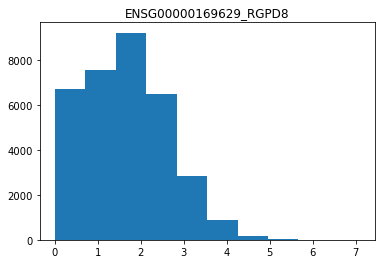

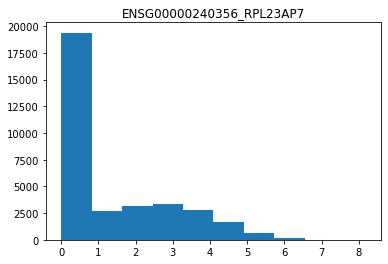

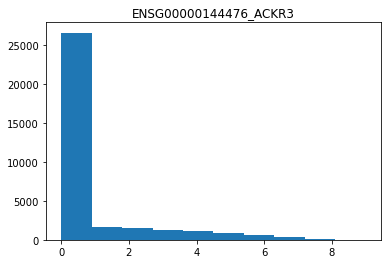

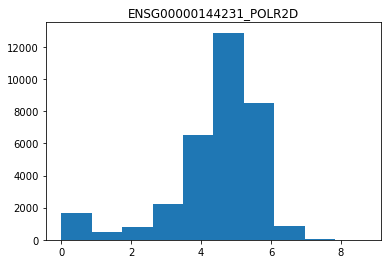

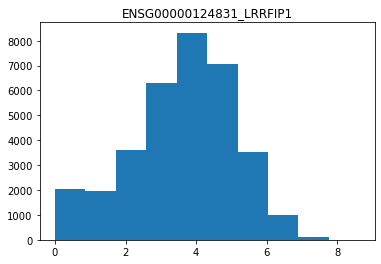

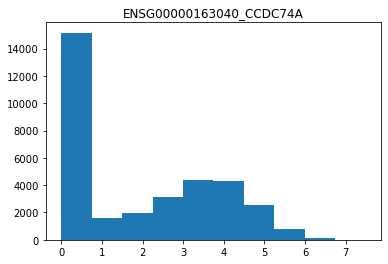

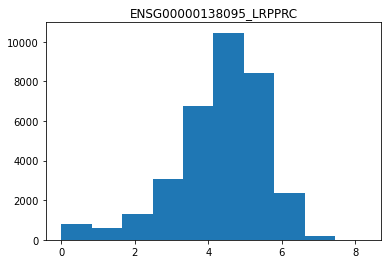

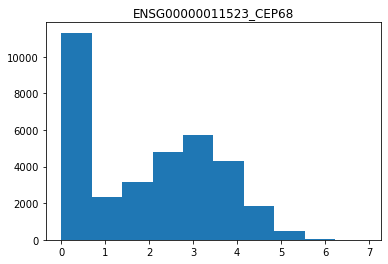

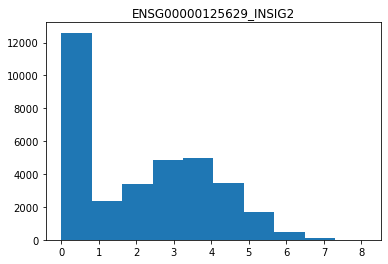

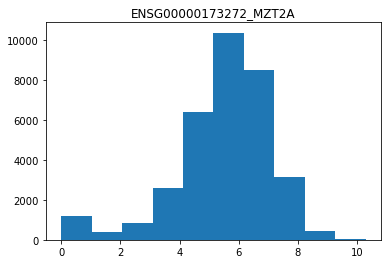

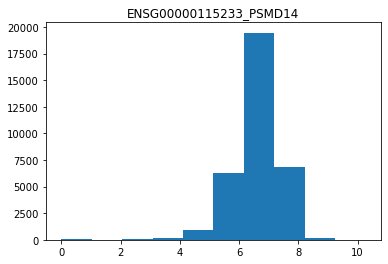

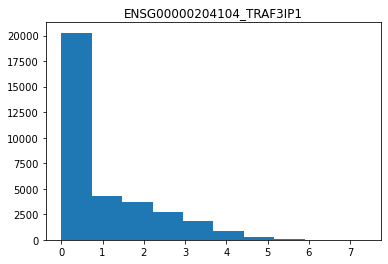

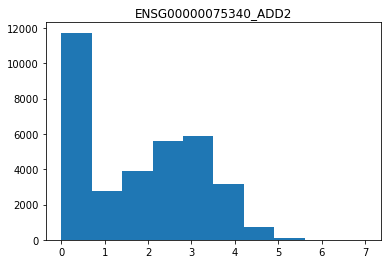

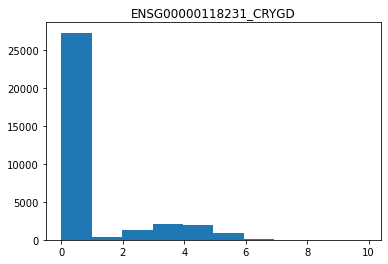

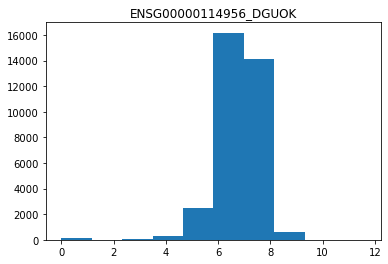

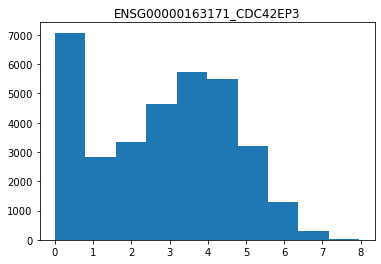

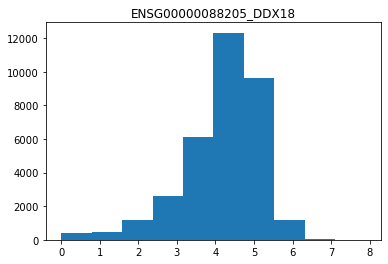

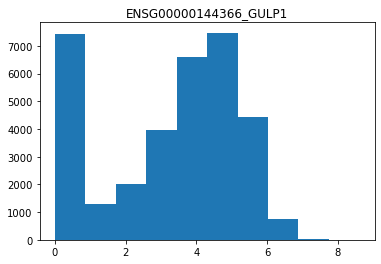

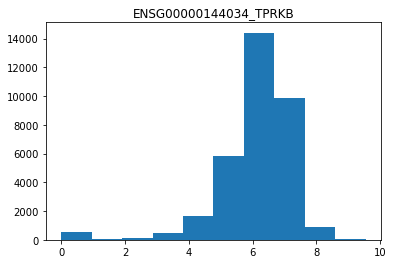

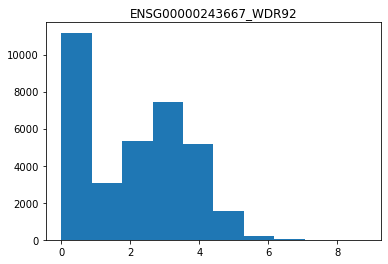

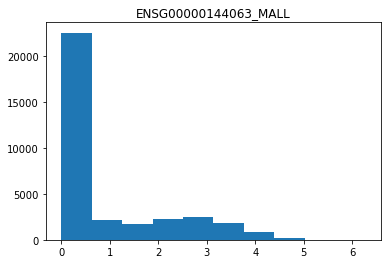

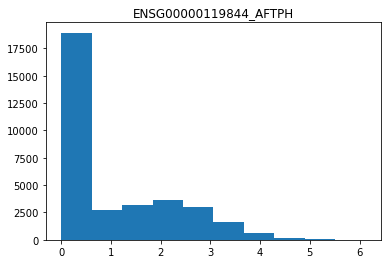

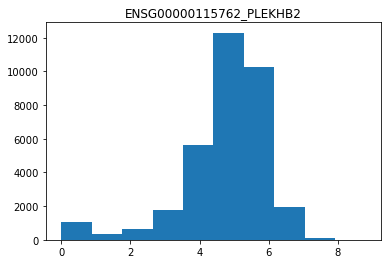

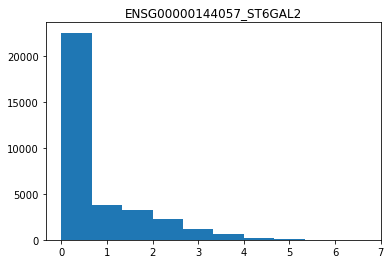

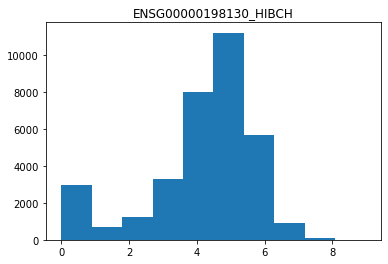

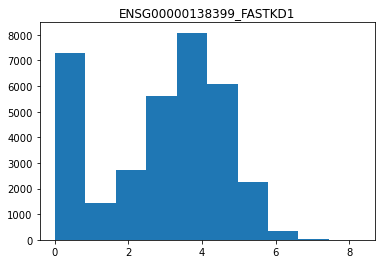

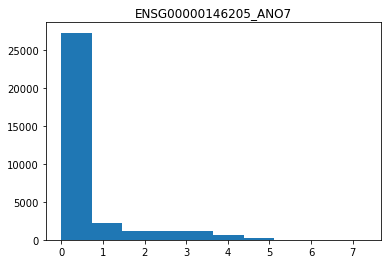

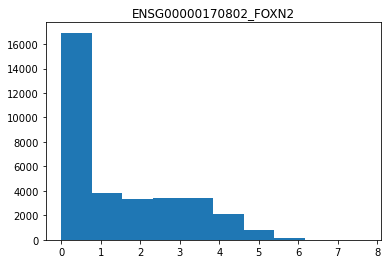

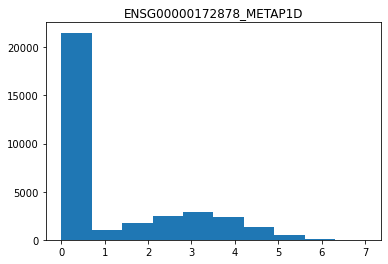

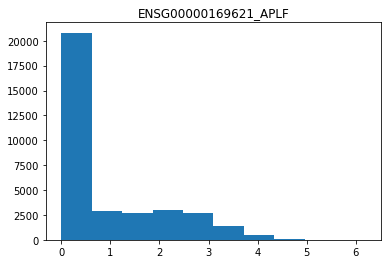

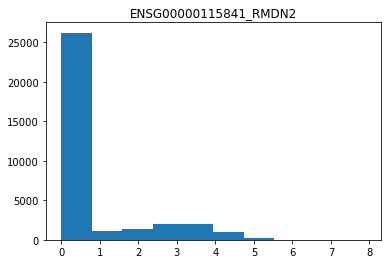

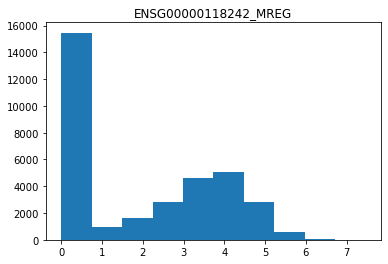

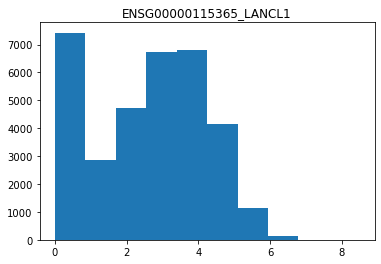

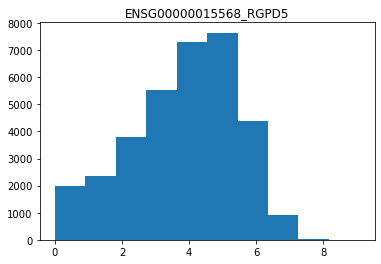

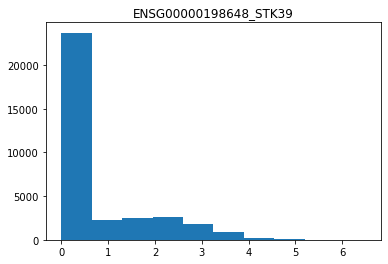

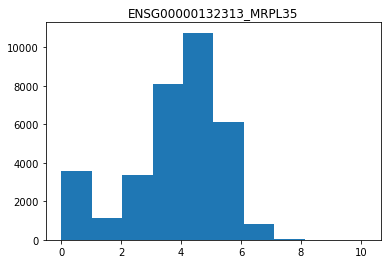

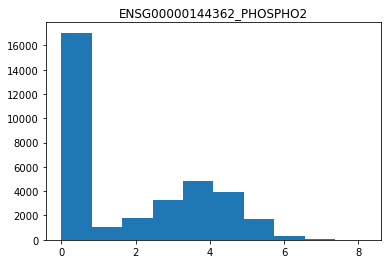

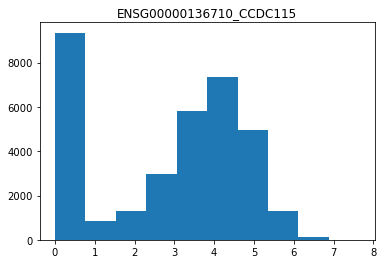

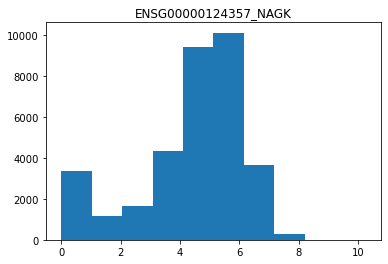

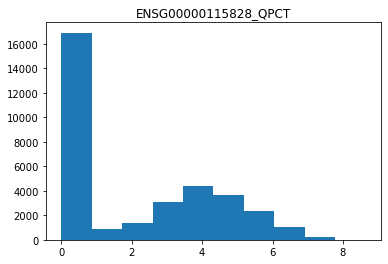

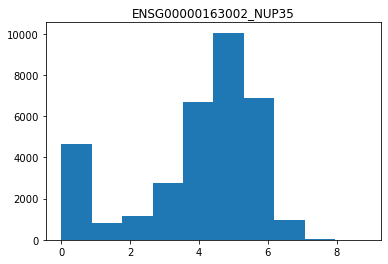

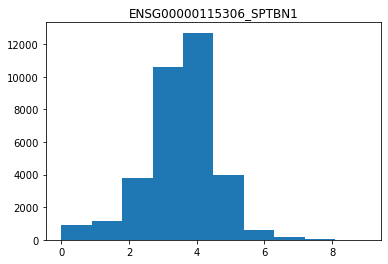

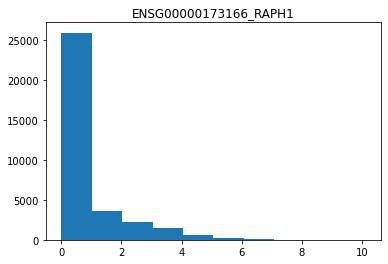

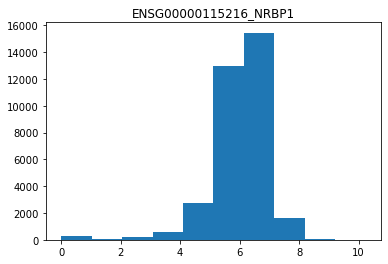

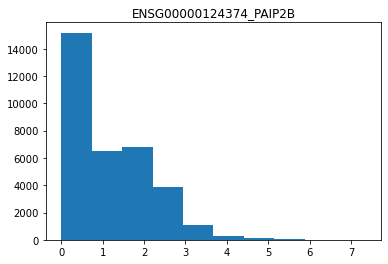

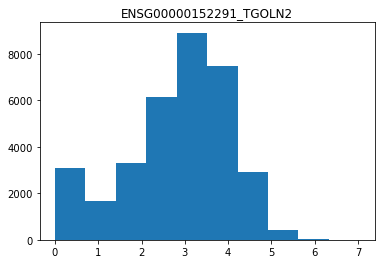

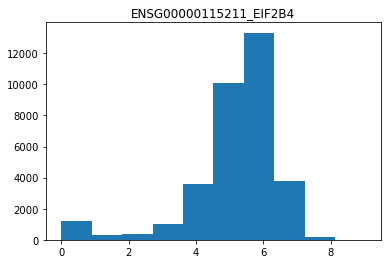

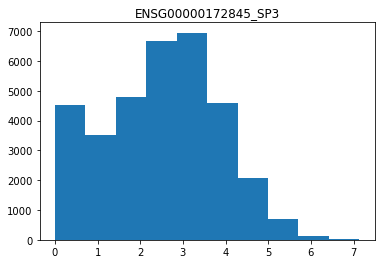

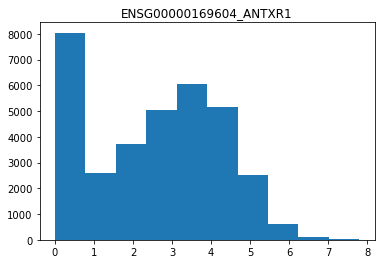

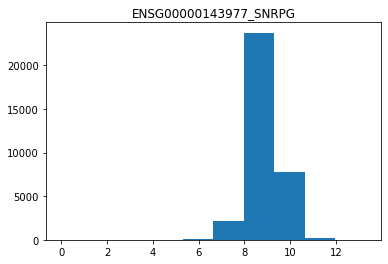

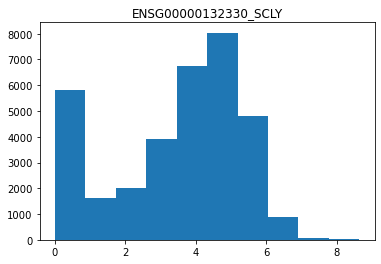

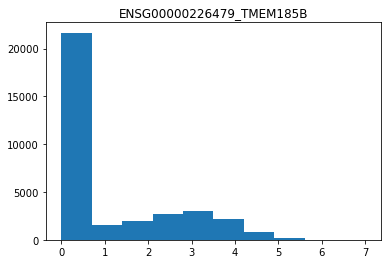

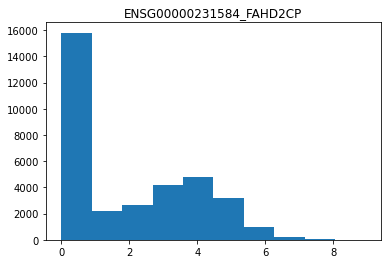

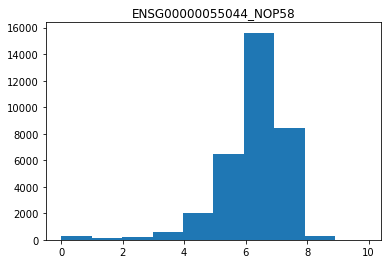

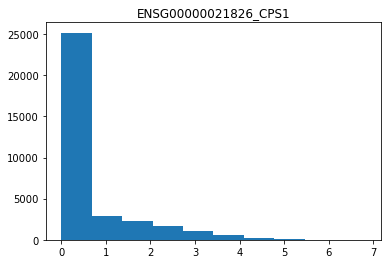

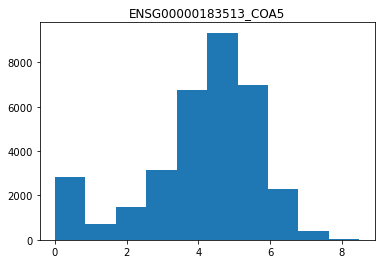

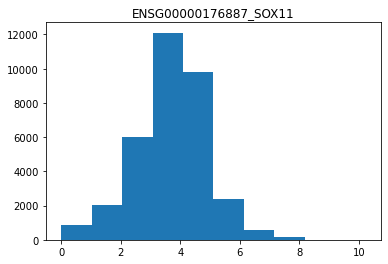

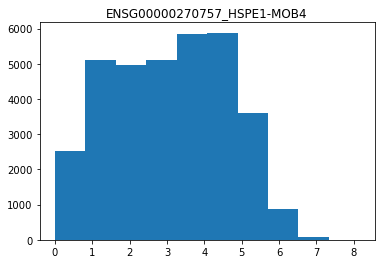

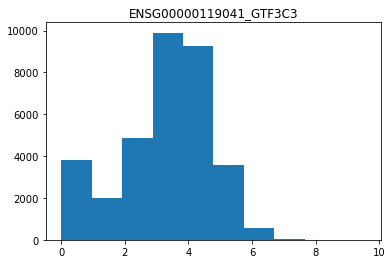

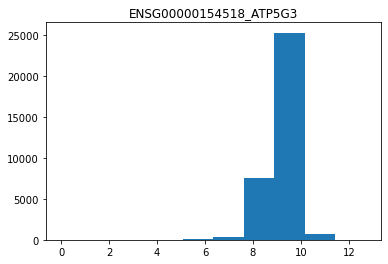

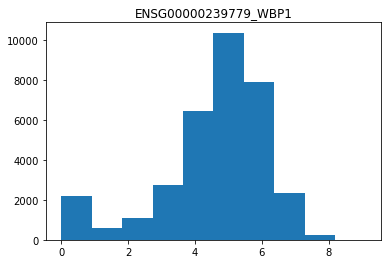

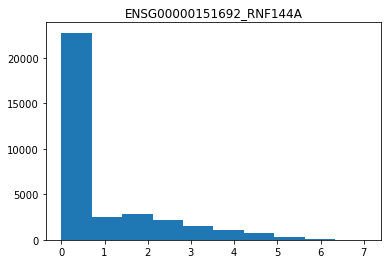

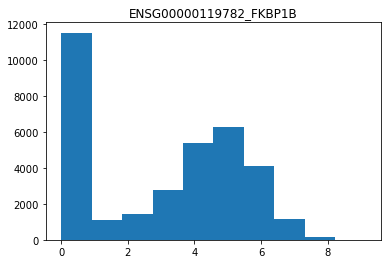

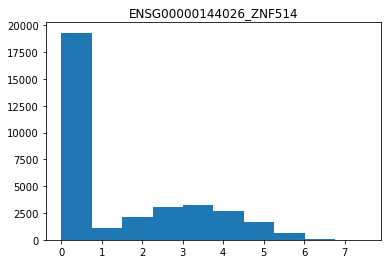

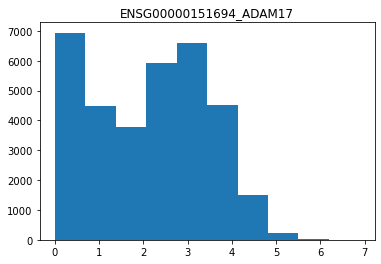

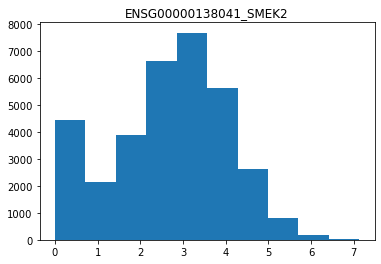

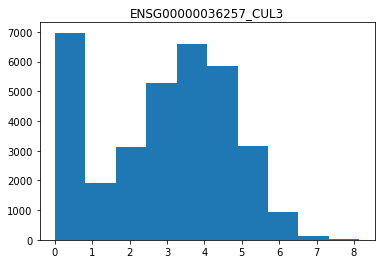

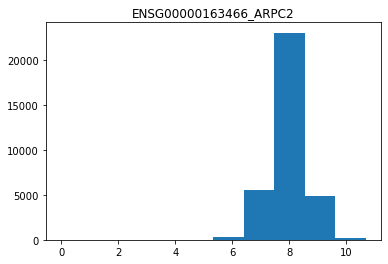

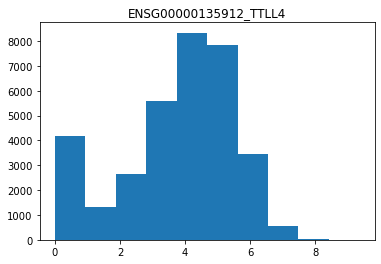

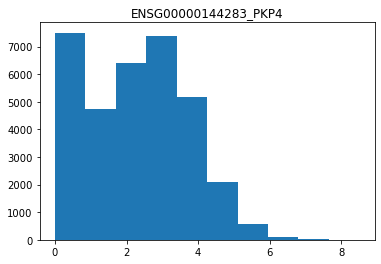

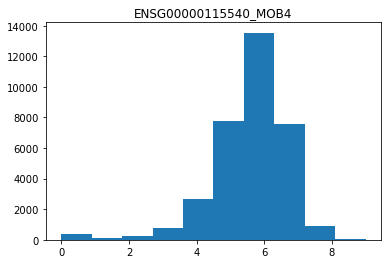

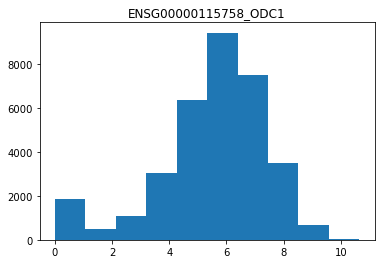

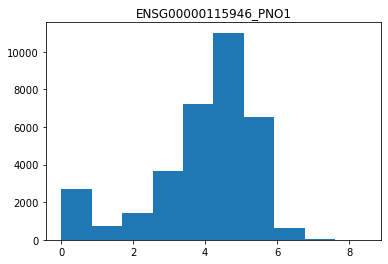

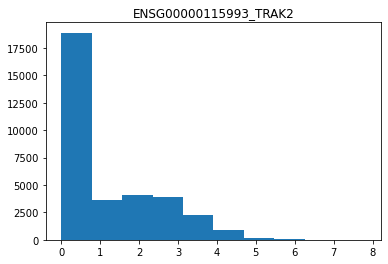

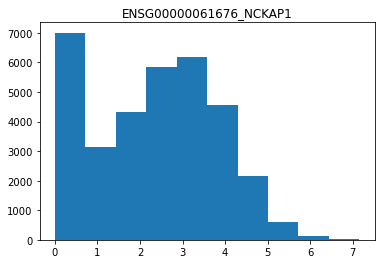

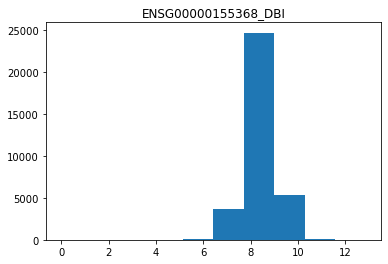

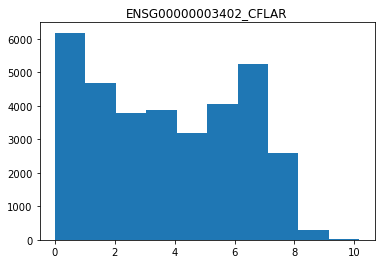

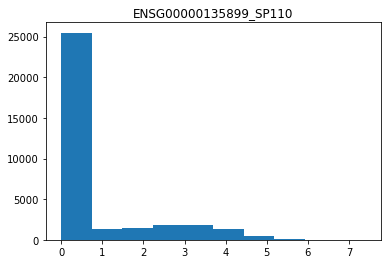

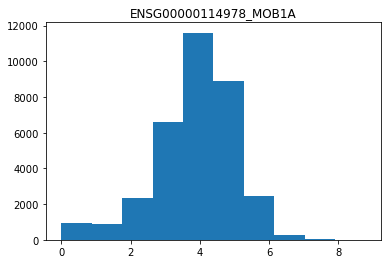

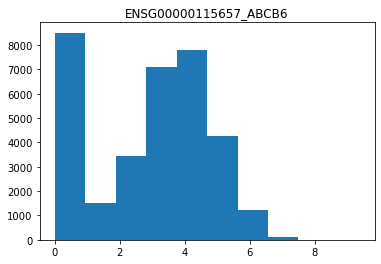

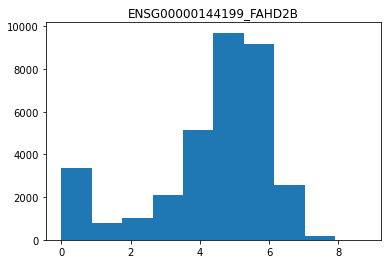

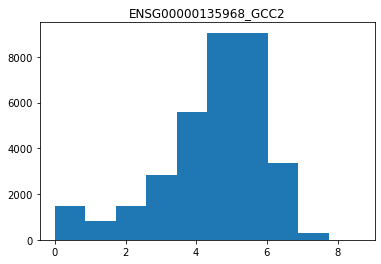

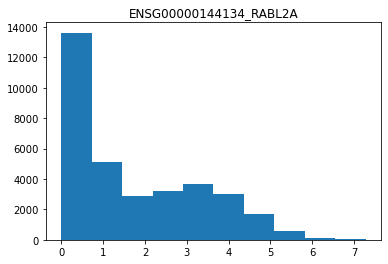

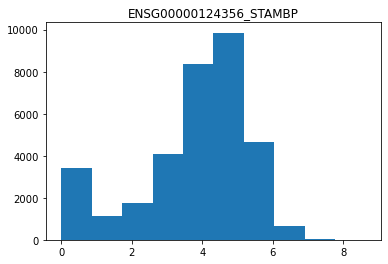

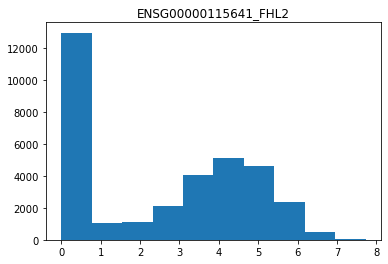

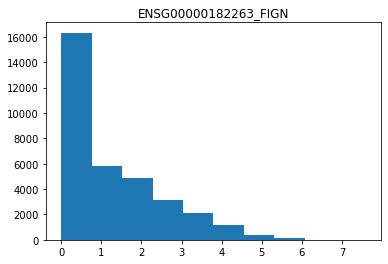

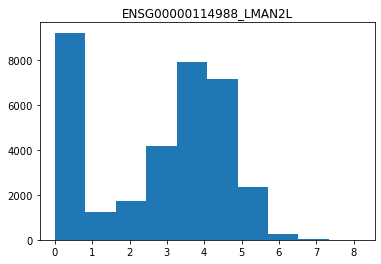

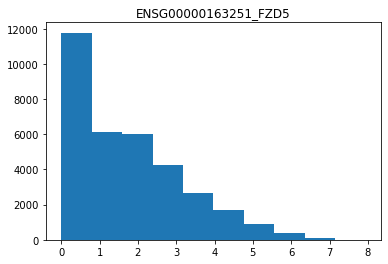

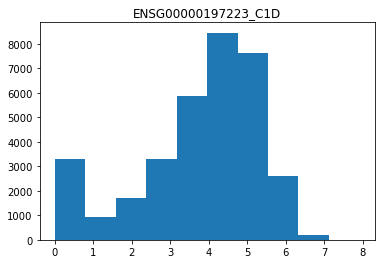

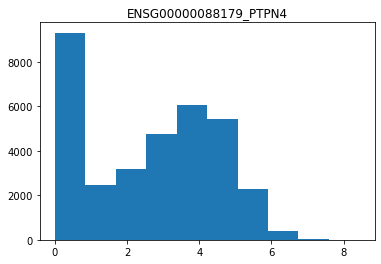

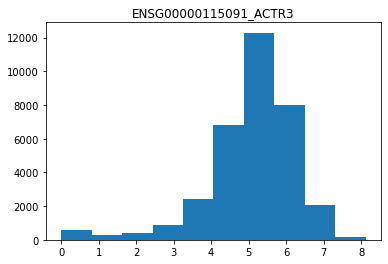

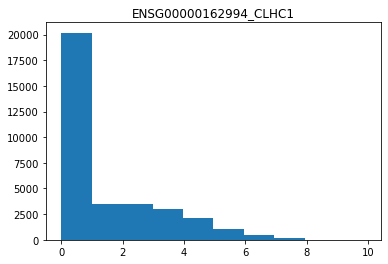

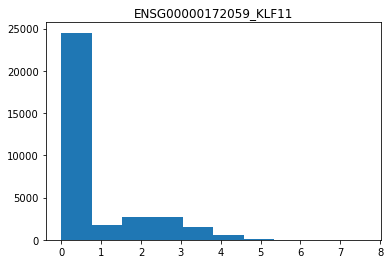

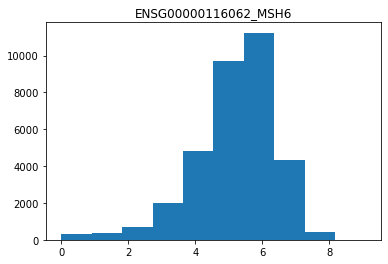

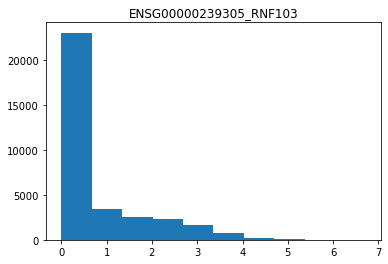

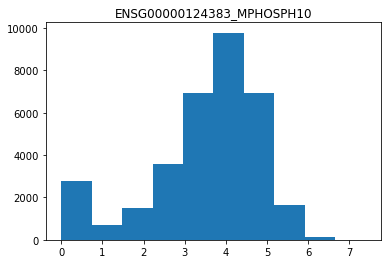

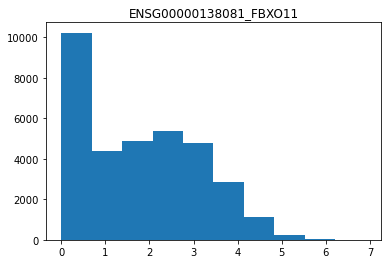

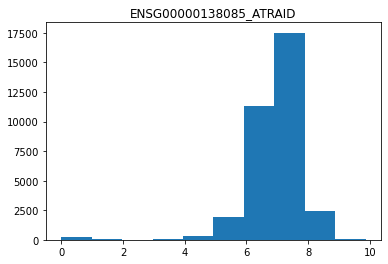

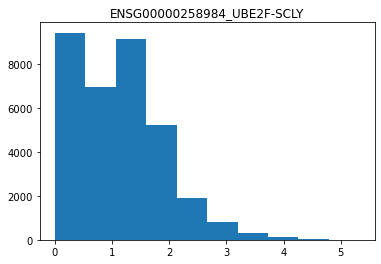

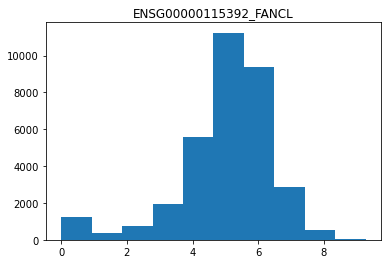

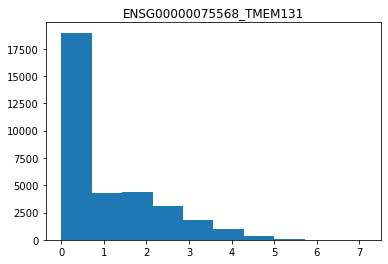

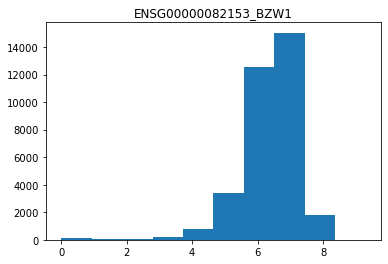

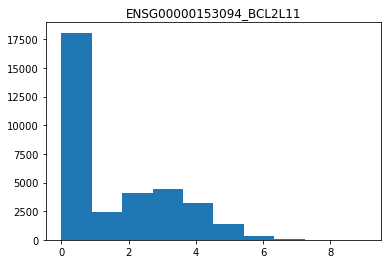

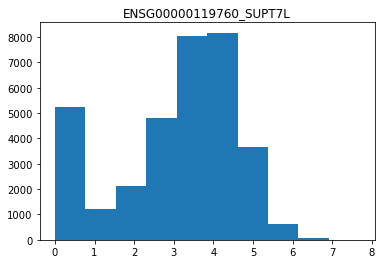

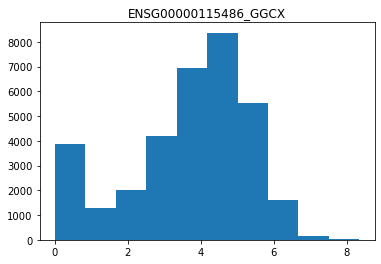

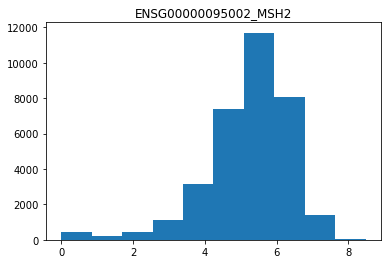

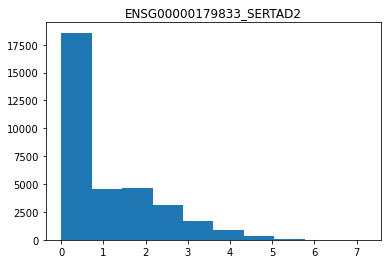

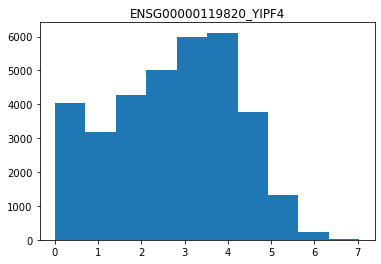

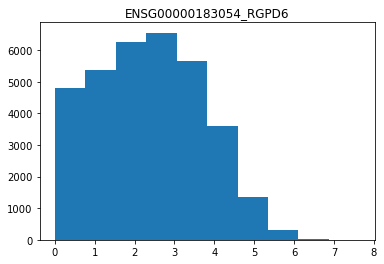

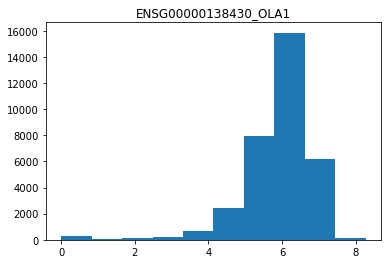

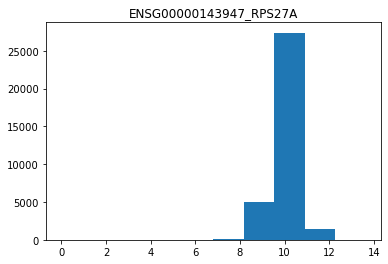

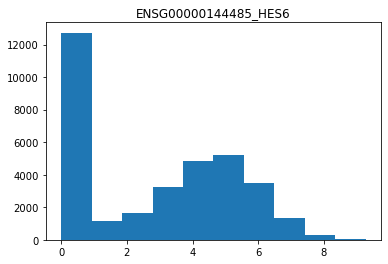

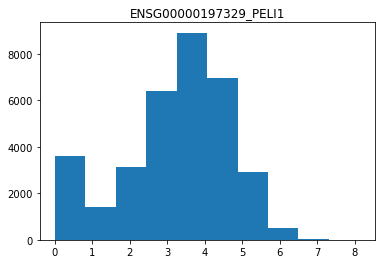

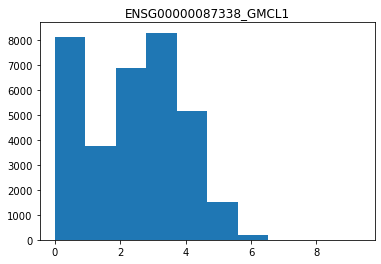

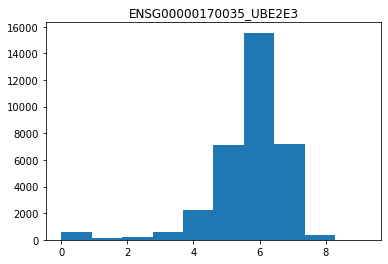

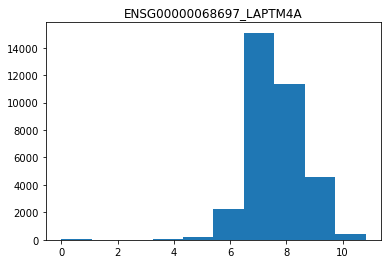

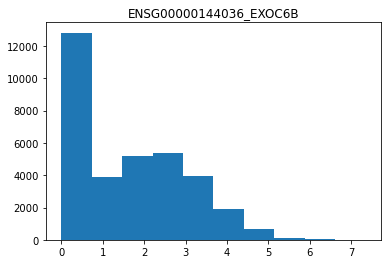

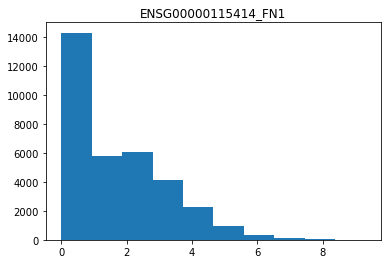

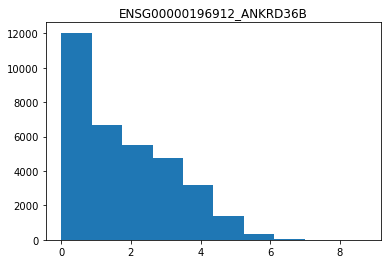

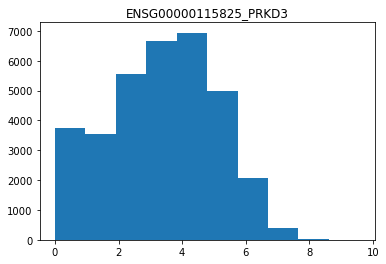

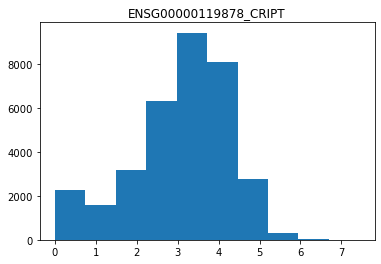

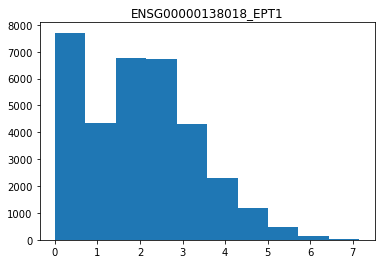

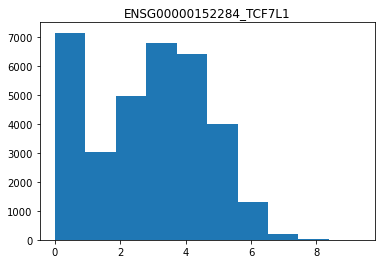

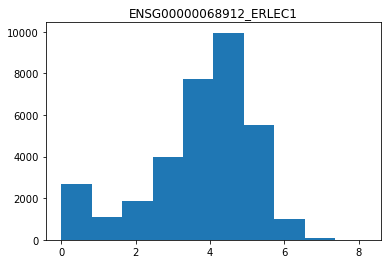

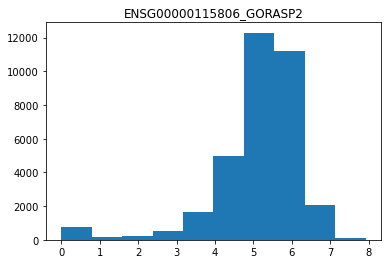

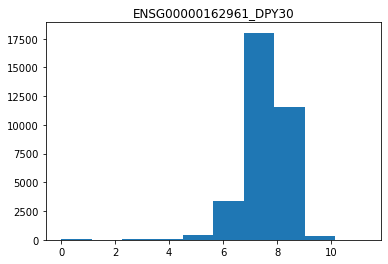

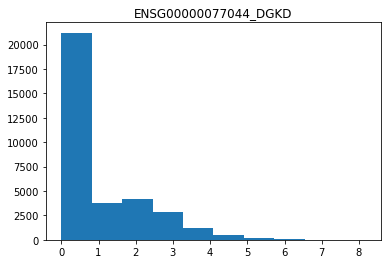

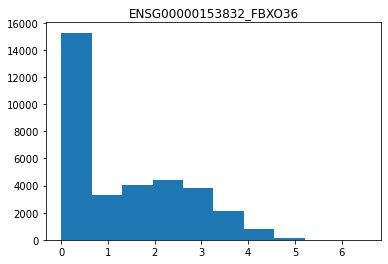

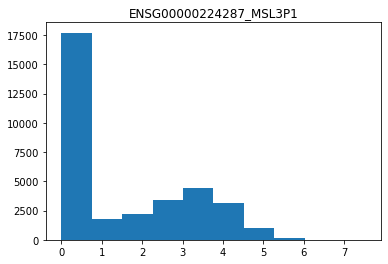

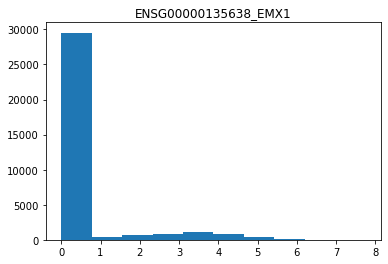

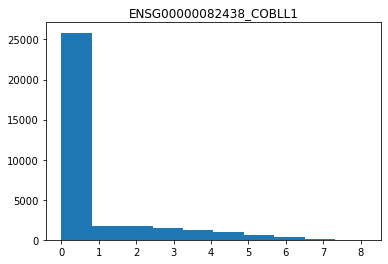

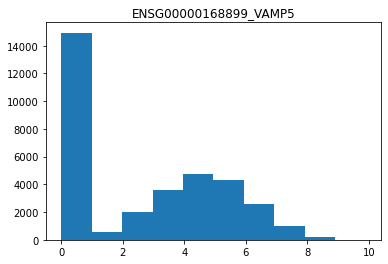

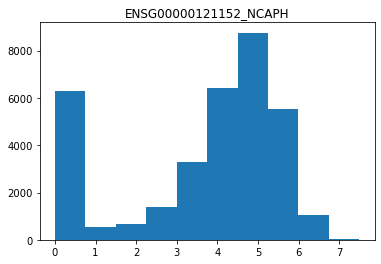

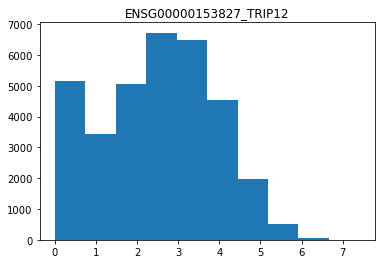

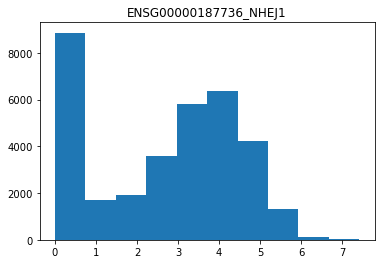

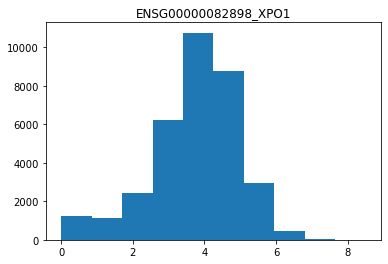

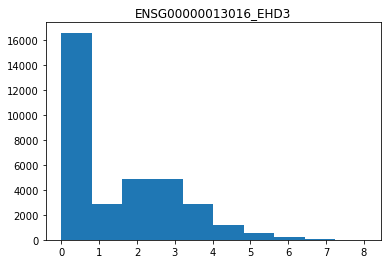

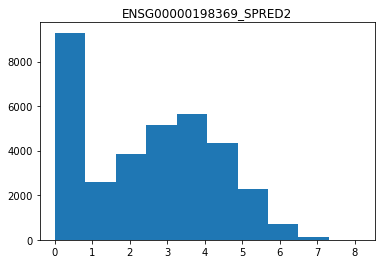

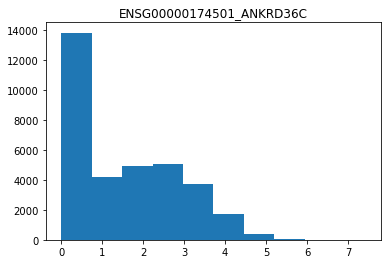

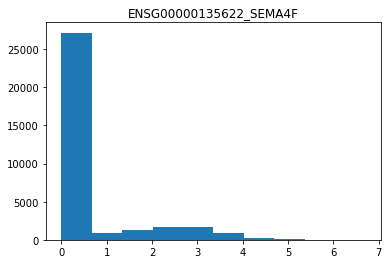

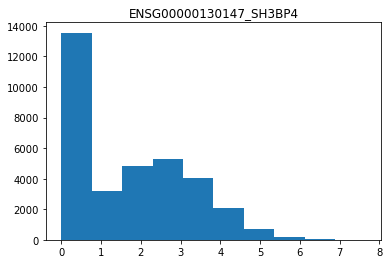

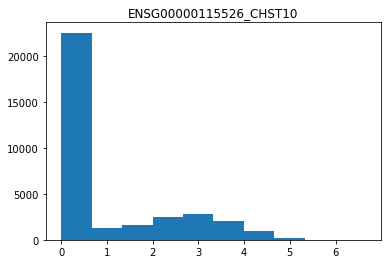

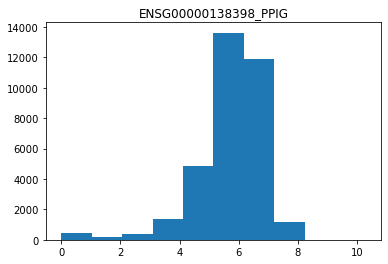

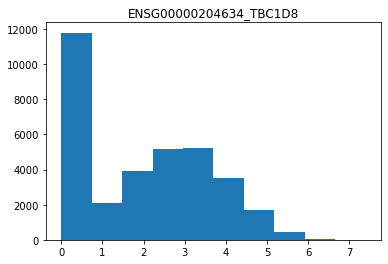

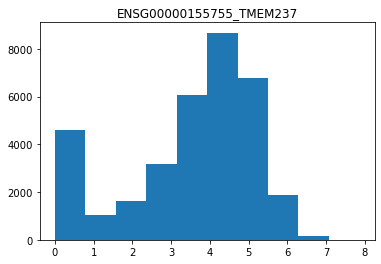

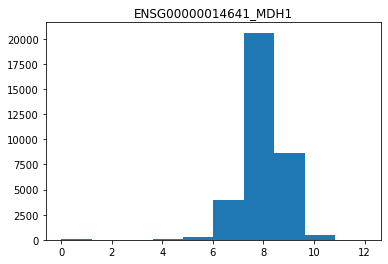

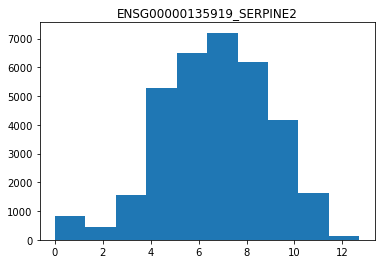

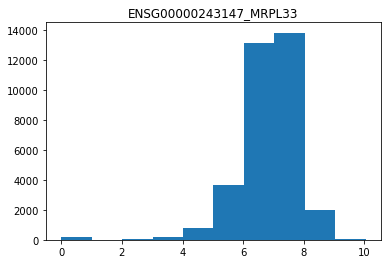

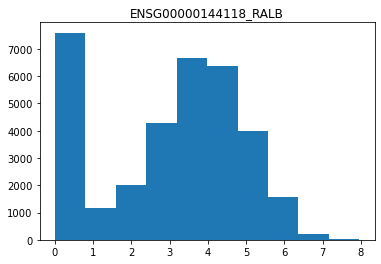

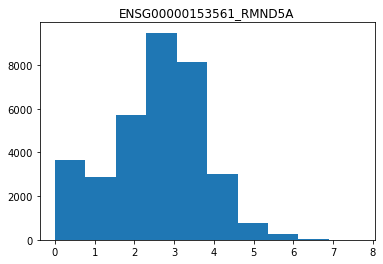

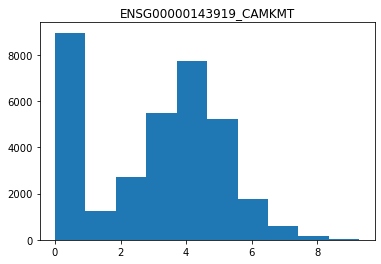

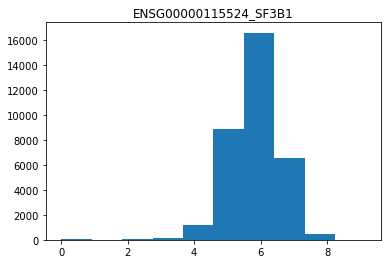

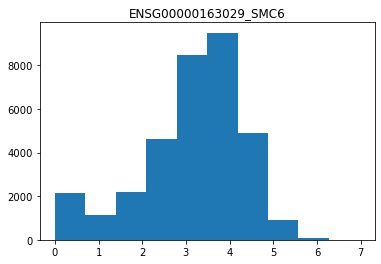

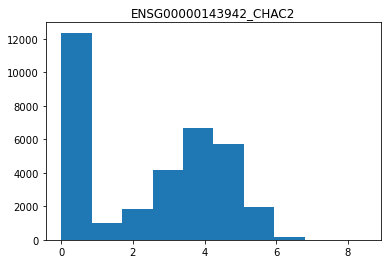

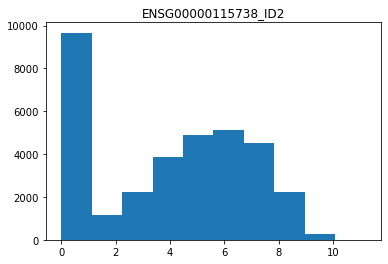

In [25]:
for trait_name in genes:
    y = phenotype.sel(trait=trait_name)
    plt.hist(y)
    plt.title(trait_name)
    plt.show()

In [26]:
# Set up model
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [27]:
# quantile normalise E
E = quantile_gaussianize(E)

In [28]:
# Pick one gene as example
i=1
trait_name = genes[i]
trait_name

'ENSG00000183891_TTC32'

In [29]:
# select SNPs for a given gene
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
print("Running for gene {}".format(trait_name))

Running for gene ENSG00000183891_TTC32


In [30]:
# plt.matshow(E.values @ E.values.T)

In [31]:
# quantile normalise y
y = phenotype.sel(trait=trait_name)

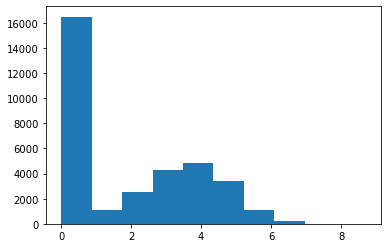

In [32]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [33]:
y = np.array(y)
(y == 0).astype(int).sum()/len(y)>0.3

True

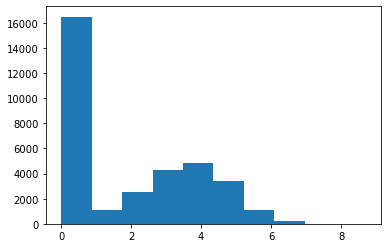

In [34]:
plt.hist(y)
plt.show()

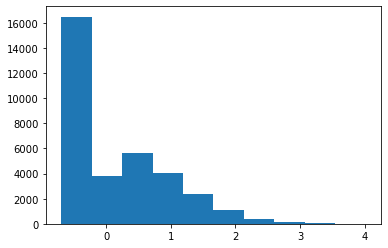

In [35]:
y = quantile_gaussianize(y)
plt.hist(y)
plt.show()

In [36]:
# null model
slmm2 = StructLMM2(y, M, E, Ls)

In [37]:
def cis_snp_selection(feature_id, annotation_df, G, window_size):
        # annotation_sub_df = annotation_df.loc[[feature_id],:]
        feature = annotation_df.query("feature_id==\"{}\"".format(feature_id)).squeeze()
        chrom = str(feature['chromosome'])
        start = feature['start']
        end = feature.loc['end']
        # make robust to features selfpecified back-to-front
        lowest = min([start,end])
        highest = max([start,end])
        # for cis, we sequentially add snps that fall within each region
        G = G.where((G.chrom == chrom) & (G.pos > lowest-window_size) & (G.pos < highest-window_size), drop=True)
        return G

In [38]:
gene_anno_file = "/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/scQTLs/annos/combined_feature_id_annos.tsv"
annotation_df = pd.read_csv(gene_anno_file, sep="\t")

In [39]:
# get only cis SNPs, MAF<5%
G_cis = cis_snp_selection(trait_name, annotation_df, G_exp, window_size = 250000).compute()

In [40]:
G_cis

<xarray.DataArray 'genotype' (sample: 33964, variant: 30)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * sample   (sample) object 'HPSI0114i-joxm_1' ... 'HPSI1113i-wahn_1'
  * variant  (variant) object '2_2_19846447_C_T' ... '2_2_19851460_A_T'
    fid      (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    iid      (sample) object 'HPSI0114i-joxm_1' ... 'HPSI1113i-wahn_1'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    gender   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    trait    (sample) object '-9' '-9' '-9' '-9' '-9' ... '-9' '-9' '-9' '-9'
    chrom    (variant) object '2' '2' '2' '2' '2' '2' ... '2' '2' '2' '2' '2'
    snp      (variant) object '2_19846447_C_T' ... '2_19851460_A_T'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pos      (variant) int32 19846447 19846831 19847034 ... 19851377 19851460
    a0       (variant) object 'C' 'G' 'C' 'T' 'A' 'G' ... 'T' 'A' 'T' 'T' 'A'
    a1       (variant) object 'T' 'C' 'T' 'A' 'G' 'T' ... 'C' 'T' 'A' 'C' 'T'

In [41]:
ok = np.var(G_cis.values, axis=0) > 0.0
pvals = np.full(G_cis.shape[1], np.nan)

In [ ]:
pvals = slmm2.scan_interaction(G_cis[:,ok], idx_E=idx_E)[0]

 33%|███▎      | 8/24 [22:54<46:11, 173.25s/it]  

In [ ]:
plt.hist(pvals)
plt.show()

In [ ]:
pv = pd.DataFrame({"chrom":G_cis[:,ok].chrom.values,
                   "pv":pvals,
                   "variant":G_cis[:,ok].snp.values})
pv.head()

In [ ]:
folder = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/PCA/"
outfilename0 = f"{folder}PCA20/{trait_name}_cis_snps_permuteE_within_donors.tsv"
pv.to_csv(outfilename0, sep='\t')